# Movie Recommendation Challenge: Team_3_CPT

# Introduction

**Problem** : Predicting how a user will rate a movie they have not yet viewed based on their historical preferences.

In today’s technology driven world, recommender systems are socially and economically critical for ensuring that individuals can make appropriate choices surrounding the content they engage with on a daily basis. One application where this is especially true surrounds movie content recommendations; where intelligent algorithms can help viewers find great titles from tens of thousands of options.

Providing an accurate and robust solution to this challenge has immense economic potential, with users of the system being exposed to content they would like to view or purchase - generating revenue and platform affinity.

# Imports

In [7]:
#Importing the required packages
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
import warnings; warnings.simplefilter('ignore')
from collections import defaultdict
from wordcloud import WordCloud
from pandas import Series, DataFrame

# The Data

In this section we will be diving deep into the data and what it offers.
We will be doing through analysis and grabbing insights.

We will start by:
* Loading the data
* Viewing the data
* Checking for nan values
* Checking the shapes
* Adding visual comparisons

In [8]:
# Loading the data
train = pd.read_csv('../input/edsa-recommender-system-predict/train.csv')
test = pd.read_csv('../input/edsa-recommender-system-predict/test.csv')
movies = pd.read_csv('../input/edsa-recommender-system-predict/movies.csv')
imdb = pd.read_csv('../input/edsa-recommender-system-predict/imdb_data.csv')
# Viewing the data
train.head()


,userId,movieId,rating,timestamp
0,5163,57669,4.0,1518349992
1,106343,5,4.5,1206238739
2,146790,5459,5.0,1076215539
3,106362,32296,2.0,1423042565
4,9041,366,3.0,833375837


In [ ]:
# Checking the shape
train.shape


In [ ]:
# Looking for nan values
train.isna().sum()


In [ ]:
# Checking the shape
test.shape


In [ ]:
# Looking for nan values
test.isna().sum()


Conclusion: both the train and test datasets contain no null values.

In [3]:
# Function for changing the labels.
def changingLabels(number):
    return str(number/10**6) + "M"
    

In [ ]:
# Plotting a bar graph to visualise distribution of ratings in the train data
plt.figure(figsize=(12, 8))
ax = sns.countplot(x="rating", data=train)
ax.set_yticklabels([changingLabels(num) for num in ax.get_yticks()])
plt.tick_params(labelsize=15)
plt.title("Distribution of Ratings in Train data", fontsize=20)
plt.xlabel("Rating", fontsize=20)
plt.ylabel("Number of Ratings (Millions)", fontsize=20)
plt.show()


We can clearly see that Ratings equal to 4.0 are most common.

We believe that the reasons for this might be because it is likely that people who truely enjoyed a specific movie will never be 100% satisfied with the movie. Giving a 5.0 rating would indicate a truly perfect movie from the watchers perspective, which is very rare. The closest best thing to 5.0 without seeming bias is 4.0, therefore 4.0 ratings are most common.

In [ ]:
no_of_ratings_per_movie = train.groupby(by="movieId")["rating"].count().sort_values(ascending=False)


In [ ]:
fig = plt.figure(figsize=(12, 6))
axes = fig.add_axes([0.1, 0.1, 1, 1])
plt.title("Number of Ratings Per Movie", fontsize=20)
plt.xlabel("Movie", fontsize=20)
plt.ylabel("Count of Ratings", fontsize=20)
plt.plot(no_of_ratings_per_movie.values)
plt.tick_params(labelsize=5)
axes.set_xticklabels([])
plt.show()


The above line graph shows that there are some movies that receive many ratings and some movies that receive very little votes.

We believe the reason for this can be the fact that some mainstream movies are way more popular and therefore receive a lot of attention compared to the other movies. 

In [39]:
no_of_rated_movies_per_user = train.groupby(by="userId")["rating"].count().sort_values(ascending=False)
no_of_rated_movies_per_user.head(10)


userId
72315     12952
80974      3680
137293     3588
33844      3208
20055      3050
109731     2671
49403      2670
92046      2579
110971     2288
30879      2284
Name: rating, dtype: int64

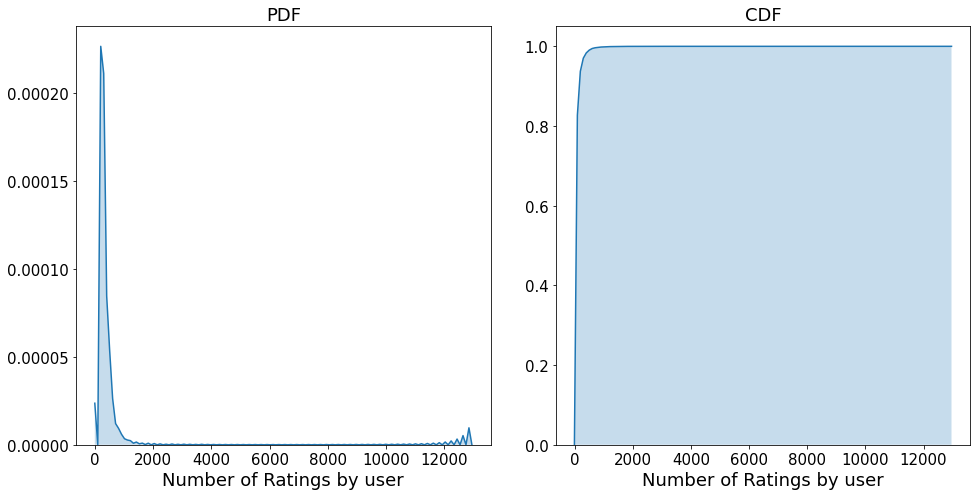

In [40]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))

sns.kdeplot(no_of_rated_movies_per_user.values, shade=True, ax=axes[0])
axes[0].set_title("PDF", fontsize=18)
axes[0].set_xlabel("Number of Ratings by user", fontsize=18)
axes[0].tick_params(labelsize=15)

sns.kdeplot(no_of_rated_movies_per_user.values, shade=True, cumulative=True, ax=axes[1])
axes[1].set_title("CDF", fontsize=18)
axes[1].set_xlabel("Number of Ratings by user", fontsize=18)
axes[1].tick_params(labelsize=15)

fig.subplots_adjust(wspace=2)
plt.tight_layout()
plt.show()


* **Above PDF graph shows that almost all of the users give very few ratings. There are very few users who's ratings count is high.**

* **The CDF graph shows that almost 99% of users give very few ratings**

In [41]:
quantiles = no_of_rated_movies_per_user.quantile(np.arange(0, 1.01, 0.01))


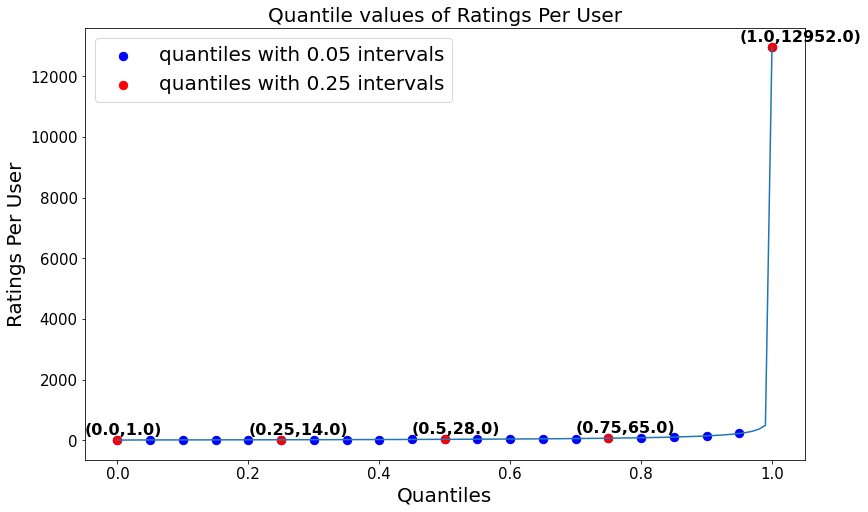

In [42]:
fig = plt.figure(figsize=(10, 6))

axes = fig.add_axes([0.1, 0.1, 1, 1])
axes.set_title("Quantile values of Ratings Per User", fontsize=20)
axes.set_xlabel("Quantiles", fontsize=20)
axes.set_ylabel("Ratings Per User", fontsize=20)
axes.plot(quantiles)

plt.scatter(x=quantiles.index[::5], y=quantiles.values[::5], c="blue", s=70, label="quantiles with 0.05 intervals")
plt.scatter(x=quantiles.index[::25], y=quantiles.values[::25], c="red", s=70, label="quantiles with 0.25 intervals")
plt.legend(loc='upper left', fontsize=20)

for x, y in zip(quantiles.index[::25], quantiles.values[::25]):
    plt.annotate(s='({},{})'.format(x, y), xy=(x, y), fontweight='bold', fontsize=16, xytext=(x-0.05, y+180))
    
axes.tick_params(labelsize=15)


Total number of ratings per user below 75th percentile are less or equal to 65 and total number of ratings per user above 75th percentile are greater than 65.

In [ ]:
quantiles[::5]

 More than 75% of users rated above 65

In [44]:
print("Total number of ratings below 75th percentile = "+str(sum(no_of_rated_movies_per_user.values<=65)))
print("Total number of ratings above 75th percentile = "+str(sum(no_of_rated_movies_per_user.values>65)))

Total number of ratings below 75th percentile = 122281
Total number of ratings above 75th percentile = 40260


**Finding the most popular genre:**

We began by creating a list of all the genres.

In [5]:
temp = ""
for i in movies.genres:
    temp = temp+'|'+i

genres_list = list(set(temp.split('|')))
del genres_list[0]  # Data Cleaning
genres_list


['Children',
 'Adventure',
 'Western',
 'Comedy',
 'Crime',
 'Animation',
 'Drama',
 'Fantasy',
 'Horror',
 'Thriller',
 'War',
 'Musical',
 'Mystery',
 'Film-Noir',
 'Romance',
 'Action',
 'Documentary',
 '(no genres listed)',
 'Sci-Fi',
 'IMAX']

In [10]:
# Split genres and create a new entry for each of the genre a movie falls into
s = movies['genres'].str.split('|').apply(Series, 1).stack()
s.index = s.index.droplevel(-1)
s.name = 'genres'
del movies['genres']
movies_split_genres = movies.join(s)

In [11]:
movies_split_genres.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure
0,1,Toy Story (1995),Animation
0,1,Toy Story (1995),Children
0,1,Toy Story (1995),Comedy
0,1,Toy Story (1995),Fantasy


In [13]:
# How many different genres do we have?
movies_split_genres['genres'].unique()

array(['Adventure', 'Animation', 'Children', 'Comedy', 'Fantasy',
       'Romance', 'Drama', 'Action', 'Crime', 'Thriller', 'Horror',
       'Mystery', 'Sci-Fi', 'IMAX', 'Documentary', 'War', 'Musical',
       'Western', 'Film-Noir', '(no genres listed)'], dtype=object)

In [14]:
len(movies_split_genres['genres'].unique())

20

Overall, we have movies from 20 unique genres.

In [15]:
# Group movies by genre using title as unique identifier and display all genres.
movies_genre = (pd.DataFrame(movies_split_genres.groupby('genres').title.nunique())).sort_values('title', ascending=True)
movies_genre.head(20)


,title
genres,
IMAX,195
Film-Noir,353
Musical,1054
Western,1399
War,1874
Fantasy,2731
Mystery,2925
Animation,2928
Children,2934


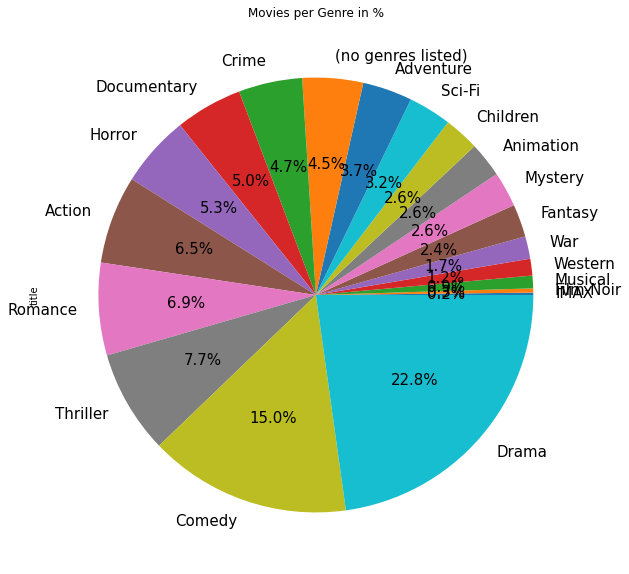

In [16]:
movies_genre['title'].plot.pie(title= 'Movies per Genre in %', figsize=(10,10), autopct='%1.1f%%',fontsize=15);


Drama, Comedy, Thriller, and Romance are the most popular genres in general. 
The pie chart is a better visual since we can assess that these top 4 genres make up about 50% of all movies.

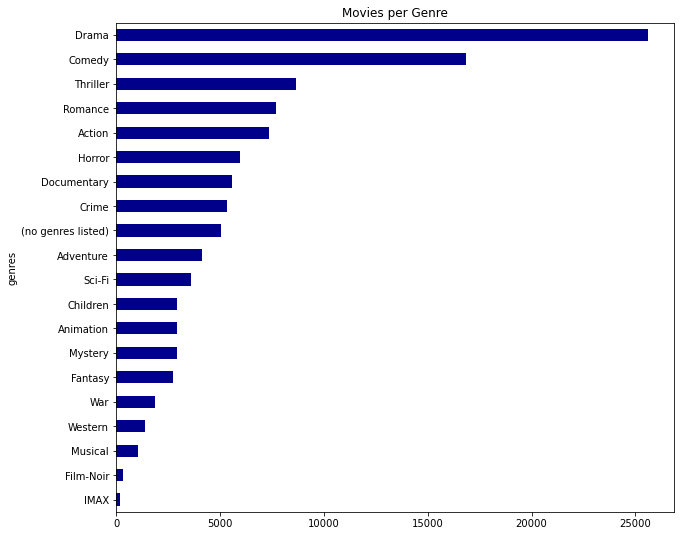

In [17]:
# Display in bar chart
movies_genre['title'].plot.barh(title = 'Movies per Genre',color='DarkBlue', figsize=(10, 9));

The most common genres are Drama (25581 movies, 22.8%) , Comedy (16861 movies, 15.0%) and Thriller (8641 movies, 7.7%).

In [18]:
imd_movies = movies.merge(imdb, on='movieId')
imd_movies.head()


,movieId,title,title_cast,director,runtime,budget,plot_keywords
0,1,Toy Story (1995),Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation
1,2,Jumanji (1995),Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh,104.0,"$65,000,000",board game|adventurer|fight|game
2,3,Grumpier Old Men (1995),Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...,Mark Steven Johnson,101.0,"$25,000,000",boat|lake|neighbor|rivalry
3,4,Waiting to Exhale (1995),Whitney Houston|Angela Bassett|Loretta Devine|...,Terry McMillan,124.0,"$16,000,000",black american|husband wife relationship|betra...
4,5,Father of the Bride Part II (1995),Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,106.0,"$30,000,000",fatherhood|doberman|dog|mansion


In [33]:
# Split genres and create a new entry for each of the genre a movie falls into
z = imd_movies['title_cast'].str.split('|').apply(Series, 1).stack()
z.index = z.index.droplevel(-1)
z.name = 'title_cast'
del imd_movies['title_cast']
imd_movies_split_title_cast = imd_movies.join(z)

**Which actors have starred in the most movies?**

In [35]:
imd_movies_split_title_cast['title_cast'].value_counts().head(15)

Samuel L. Jackson     79
Steve Buscemi         65
Robert De Niro        57
Willem Dafoe          55
Nicolas Cage          55
Gérard Depardieu      55
Christopher Walken    54
Keith David           54
Brian Cox             54
Bruce Willis          54
Danny Glover          53
Richard Jenkins       53
Morgan Freeman        53
Stanley Tucci         53
Tom Wilkinson         53
Name: title_cast, dtype: int64

Samuel L. Jackson,Steve Buscemi and Robert De Niro starred in most movies    

**Who has directed the most movies?**

In [37]:
imd_movies['director'].value_counts().head(15)

Woody Allen            26
Luc Besson             26
See full summary       25
Stephen King           23
William Shakespeare    18
Ki-duk Kim             15
Tyler Perry            15
Lars von Trier         15
Robert Rodriguez       14
David Mamet            13
Alex Gibney            13
Peter Farrelly         13
Sang-soo Hong          12
Takeshi Kitano         12
Olivier Assayas        12
Name: director, dtype: int64

Woody Allen,Luc Besson,See full summary and  Stephen King directed the most movies.                
       

# Collaborative Filtering

We will use a technique called collaborative filtering to make recommendations to movie watchers. Collaborative filtering is the most common technique used when it comes to building intelligent recommender systems that can learn to give better recommendations as more information about users is collected.Collaborative filtering provides many advantages over content-based filtering. A few of them are as follows: Not required to understand item content: The content of the items does not necessarily tell the whole story, such as movie type/genre, and so on.

We will not be implementing collaborative filtering from scratch. Instead, we will use the Surprise library that used extremely powerful algorithms like Singular Value Decomposition (SVD) to minimise RMSE (Root Mean Square Error) and give great recommendations.

Most websites like Amazon, YouTube, and Netflix use collaborative filtering as a part of their sophisticated recommendation systems. We can use this technique to build recommenders that give suggestions to a user on the basis of the likes and dislikes of similar users.

In [ ]:
# Run if running from colab
!pip install scikit-surprise

In [ ]:
# Importing the surprise packages we need
from surprise.model_selection import KFold
from surprise import NormalPredictor
from surprise import SVD
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
from surprise.model_selection import cross_validate
reader = Reader(rating_scale=(1, 5))

In [ ]:
data = Dataset.load_from_df(train[['userId', 'movieId', 'rating']], reader=reader)
cross_validate(NormalPredictor(), data, cv=2)


# Model Building

We chose to use a **Single Value Decomposition (SVD)** algorithm:

One way to handle the scalability and sparsity issue created by colaborative filtering is to leverage a latent factor model to capture the similarity between users and items. Essentially, we want to turn the recommendation problem into an optimization problem. We can view it as how good we are in predicting the rating for items given a user. One common metric is Root Mean Square Error (RMSE). The lower the RMSE, the better the performance.

The latent factor you might be wondering is a broad idea which describes a property or concept that a user or an item has. SVD decreases the dimension of the utility matrix by extracting its latent factors. Essentially, we map each user and each item into a latent space with dimension r. Therefore, it helps us better understand the relationship between users and items as they become directly comparable. 

In [ ]:
kf = KFold(n_splits=3)
algo = SVD()

for trainset, testset in kf.split(data):

    # train and test algorithm.
    algo.fit(trainset)
    predictions = algo.test(testset)

    # Compute and print Root Mean Squared Error
    accuracy.rmse(predictions, verbose=True)


Fitting our algorithm on the whole dataset.

In [ ]:
# n_epochs=10, lr_all=0.005, reg_all=0.4

In [ ]:
algo.fit(data.build_full_trainset())

In [ ]:
# This for loop generates a list containing all our predictions.
ratings = []
for _, row in test.iterrows():
    ratings.append(algo.predict(row.userId, row.movieId).est)

ratings[0:10]


In [ ]:
test['rating'] = ratings
test.head()


In [ ]:
test['Id'] = test[['userId', 'movieId']].astype(str).agg('_'.join, axis=1)


In [ ]:
# Creating our submission csv file. Score of 0.81885.
test_df = test.copy()
test_df.drop(columns=['movieId', 'userId'], inplace=True)
test_df.to_csv('Submission_5.csv', index=False)
test_df


In [ ]:
ratings_dict = {'itemId': list(train.movieId),
                'userId': list(train.userId),
                'rating': list(train.rating)}

df = pd.DataFrame(ratings_dict)
df.head()


Let's check how good or bad our predictions are:
The following function will create a pandas data frame which will consist of these columns:

UID: user-id

iid: item id

Rui: the rating given by the user

est: rating estimated by the model

Iu: No of items rated by the user

UI: number of users that have rated this item

err: abs difference between predicted rating and the actual rating.

In [ ]:
def get_Iu(uid):
    """ 
    args: 
      uid: the id of the user
    returns: 
      the number of items rated by the user
    """
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError:  # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    """ 
    args:
      iid: the raw id of the item
    returns:
      the number of users that have rated the item.
    """
    try: 
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:
        return 0

    
df_predictions = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
df_predictions['Iu'] = df_predictions.uid.apply(get_Iu)
df_predictions['Ui'] = df_predictions.iid.apply(get_Ui)
df_predictions['err'] = abs(df_predictions.est - df_predictions.rui)


In [ ]:
df_predictions.head(10)


 # Top 10 best and worst predictions by model

In [ ]:
best_predictions = df_predictions.sort_values(by='err')[:10]
worst_predictions = df_predictions.sort_values(by='err')[-10:]


In [ ]:
best_predictions


In [ ]:
worst_predictions


The worst predictions look pretty surprising. Let's look in more detail of item "2571", rated 0.5, our SVD algorithm predicts that user would rate 5.0

In [ ]:
df.loc[df['itemId'] == 2571]['rating'].describe()


This shows that more than 50% users rated this item 4.5 

In [ ]:
# temp = df.loc[df['itemId'] == 4031]['rating']
# configure_plotly_browser_state()

# # Create trace
# trace = go.Histogram(x = temp.values,
#                      name = 'Ratings',
#                      xbins = dict(start = 0,
#                                   end = 5, size=.3))
#  # Create layout
# layout = go.Layout(title = 'Number of ratings item 4031 has received',
#          xaxis = dict(title = 'Number of Ratings Per Item'),
#          yaxis = dict(title = 'Count'),           
#          bargap = 0.2)

# # Create plot
# fig = go.Figure(data=[trace], layout=layout)
# iplot(fig)
# configure_plotly_browser_state()

# # Create trace
# trace = go.Histogram(x = temp.values,
#                      name = 'Ratings',
#                      xbins = dict(start = 0,
#                                   end = 5, size=.3))
#  # Create layout
# layout = go.Layout((title = 'Number of ratings item 3996 has received'),
#          xaxis = dict(title = 'Number of Ratings Per Item'),
#          yaxis = dict(title = 'Count'),
#          bargap = 0.2)  

# # Create plot
# fig = go.Figure(data=[trace], layout=layout)
# iplot(fig)

In [ ]:
#It turns out, most of the ratings this Item received between "3 and 5",only 1% of the users rated "0.5" and one "2.5"below 3. It seems that for each prediction, the users are some kind of outliers and the item has been rated very few number of times.

# K Recommendations

Recall and precision at K Recall and precision are the classical evaluation metric and are used to evaluate the binary metric and so we have to convert our rating which is scaled from (1-5) into a binary problem relevant and not relevant items.

#Conversion to binary

To do the translation we have to select an arbitrary value on which we can say any rating above that will be considered relevant. There are many methods on selecting that value but for now, we will select 3.5 as the threshold, which means any true rating above 3.5 will be considered relevant and below will be not relevant.

Deciding 'k'

In recommendation systems, we are interested in showing the top N items to users and so the best way is to compute precision and recall on top N values instead of calculating on all the items.

Definition of Relevant and Recommended
Relevant: True Rating > = 3.5

Irrelevant: True Rating < 3.5

Recommended item: Predicted Rating > = 3.5

Not Recommended item: Predicted Rating > = 3.5

Definition of Precision and Recall
Precision: It tries to answer "What proportion of positive identifications was actually correct?" i.e True positive / (True positive+False Positive) in RecSys we can say (number of recommended items at k that are relevant) / (number of recommended items at k)

Recall: It tries to answer "What proportion of actual positives were identified correctly?" i.e True positive / (True Positive+False Negative) in RecSys we can say (# of recommended items @k that are relevant) / (# of relevant items @k)

While recall expresses the ability to find all relevant instances in a dataset, precision expresses the proportion of the data points our model says was relevant actually were relevant.

In some circumstances, we might know that we need to maximize either recall or precision at the cost of the other metric. For example, in disease screening of patients, we would probably want a recall near 1.0 i.e. we want to find all patients who have the disease.

However, in cases where we want to obtain an optimal blend of precision and recall, we can use F1 score which is the harmonic mean of precision and recall taking both metrics into account while calculating it.

f1 score = 2 * (precision * recall) / (precision + recall)

The below function computes precision and recall and F1 socre as explained above.

In [ ]:
#Calculate TP,FP,TN,FN at every threshold level (0.0 - 5.0)
final = []

for threshold in np.arange(0, 5.5, 0.5):
    tp=0
    fn=0
    fp=0
    tn=0
    temp = []

    for uid, _, true_r, est, _ in predictions:
        if(true_r>=threshold):
            if(est>=threshold):
                tp = tp+1
            else:
                fn = fn+1
        else:
            if(est>=threshold):
                fp = fp+1
            else:
                tn = tn+1   

        if tp == 0:
            precision = 0
            recall = 0
            f1 = 0
        else:
            precision = tp / (tp + fp)
            recall = tp / (tp + fn)
            f1 = 2 * (precision * recall) / (precision + recall)  

    temp = [threshold, tp,fp,tn ,fn, precision, recall, f1]
    final.append(temp)

results = pd.DataFrame(final)
results.rename(columns={0:'threshold', 1:'tp', 2: 'fp', 3: 'tn', 4:'fn', 5: 'Precision', 6:'Recall', 7:'F1'}, inplace=True)
results

As per the results above, the optimal value for threshold is 2.5.

The next step is to find the optimal K value, and to find if we have to first calculate precision and recall for all the K values(2-10) having threshold value 2.5.

Below is the function to calculate precision and recall at K.

In [ ]:
def precision_recall_at_k(predictions, k, threshold):
    '''Return precision and recall at k metrics for each user.'''

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1

        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1

    #tp = n_rel_and_rec_k
    #fn =  n_rel - tp
    #fp = n_rec_k - tp
    return precisions, recalls
    

In [ ]:
results=[]
for i in range(2, 11):
    precisions, recalls = precision_recall_at_k(predictions, k=i, threshold=2.5)

    # Precision and recall can then be averaged over all users
    prec = sum(prec for prec in precisions.values()) / len(precisions)
    rec = sum(rec for rec in recalls.values()) / len(recalls)
    results.append({'K': i, 'Precision': prec, 'Recall': rec})
    

results


In [ ]:
Rec = []
Precision = []
Recall = []
for i in range(0, 9):
    Rec.append(results[i]['K'])
    Precision.append(results[i]['Precision'])
    Recall.append(results[i]['Recall'])

plt.plot(Rec, Precision)
plt.xlabel('# of Recommendations')
plt.ylabel('Precision')
plt2 = plt.twinx()
plt2.plot(Rec, Recall, 'r')
plt.ylabel('Recall')

for tl in plt2.get_yticklabels():
    tl.set_color('r')


As the graph states, Precision drops significantly when K=4

So we will consider the value of K to be 4.

 #  Testing Model's Recommendation Ability

As we know the optimal number of recommendations to provide, it's time to give recommendations to users. To do so we have to predict ratings for the movies which user have not yet watched.

Here we will be using build_anti_testset() method to get the data for testset as we have to predict ratings for the (user, item) pairs which are not present.

In [ ]:
# trainset = data.build_full_trainset()   #Build on entire data set
# algo = SVD(n_epochs=10, lr_all=0.005, reg_all=0.4)
# algo.fit(trainset)

# # Predict ratings for all pairs (u, i) that are NOT in the training set.
# testset = trainset.build_anti_testset()

# #Predicting the ratings for testset
# predictions = algo.test(testset)

In [ ]:
def get_all_predictions(predictions):
    
    # First map the predictions to each user.
    top_n = defaultdict(list)    
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)

    return top_n
    

In [ ]:
all_pred = get_all_predictions(predictions)


As we have all the predicted rating, we'll subset to only top K movies for every user, where K is 4

In [ ]:
#To get top 4 recommendation
n = 4

for uid, user_ratings in all_pred.items():
    user_ratings.sort(key=lambda x: x[1], reverse=True)
    all_pred[uid] = user_ratings[:n]
    

In [ ]:
tmp2 = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in all_pred.items() ]))
tmp2
tmp_transpose = tmp2.transpose()


In [ ]:
tmp_transpose


Now we have a dataframe which consits of top 4 movies recommended to every user.
Let's try one example and find recommendations for user 67.

Also in our streamlit app.

In [ ]:
def get_predictions(user_id):
    results = tmp_transpose.loc[user_id]
    return results
    

In [ ]:
user_id = 67
results = get_predictions(user_id)
results


Above matrix is showing top "4" recommendations for user 67. (Movie-id, Predicted-Rating).
But we just need the movies not the ratings, so let's extract the movie id's from the result.

In [ ]:
recommended_movie_ids = []
for x in range(0, n):
    recommended_movie_ids.append(results[x][0])

recommended_movie_ids


Now as we have the movie-id's to be recommended, Let's find out the movie details of those id's by reading the movie data.

In [ ]:
movies = pd.read_csv('movies.csv')
movies.head()
recommended_movies = movies[movies['movieId'].isin(recommended_movie_ids)]
recommended_movies


In [ ]:
ratings_dict = {'itemId': list(train.movieId),
                'userId': list(train.userId),
                'rating': list(train.rating)}

df = pd.DataFrame(ratings_dict)
df.head()


In [ ]:
temp = df[df['userId'] == 67].sort_values("rating", ascending = False)
temp.head()


In [ ]:
temp.shape


We can see that user 67 have rated 49 movies

In [ ]:
history_movie_ids = temp['itemId']
user_history = movies[movies['movieId'].isin(history_movie_ids)]


In [ ]:
user_history[:n]


Now we can compare the results with the user history and see how relevant the recommendations are.


Above is the user history and below the recommended movies

In [ ]:
recommended_movies


The history of the user tells that they enjoy movies in the Adventure, Children,Animation, Drama, Comedy, Action and War genres. Our model recommends movies in the same genres, this gives us a good indication that our model has very good predictive/recommendation ability.

# Appendix A

This section contains things that might have not worked, our previous models and some testing we did. Feel free to have a look at everything we attempted. 


In [ ]:
from surprise.model_selection import GridSearchCV
param_grid = {'n_epochs': [5, 10],
              'lr_all': [0.002, 0.005],
              'reg_all': [0.4, 0.6]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)
gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])


In [ ]:
from surprise.model_selection import train_test_split

# Setting the data variable and using the Reader() object.
data = Dataset.load_from_df(train[['userId', 'movieId', 'rating']], reader=reader)

# sample random trainset and testset
# test set is made of 25% of the ratings.
trainset, testset = train_test_split(data, test_size=.25)

# We'll use the famous SVD algorithm.
algo = SVD(n_epochs=10, lr_all=0.005, reg_all=0.4)

# Train the algorithm on the trainset, and predict ratings for the testset
algo.fit(trainset)
predictions = algo.test(testset)

# Then compute RMSE
accuracy.rmse(predictions)

In [ ]:
# Using algorithm with best 'rmse'
algo = gs.best_estimator['rmse']

# Fitting it to our full trainset
algo.fit(data.build_full_trainset())

In [ ]:
ratings = []
for _, row in test.iterrows():
    ratings.append(algo.predict(row.userId, row.movieId).est)

ratings

In [ ]:
results_df = pd.DataFrame.from_dict(gs.cv_results)
results_df

Looking at the other data:

In [ ]:
movies = pd.read_csv('movies.csv')
genome_scores = pd.read_csv('genome_scores.csv')
genome_tags = pd.read_csv('genome_tags.csv')
imdb_data = pd.read_csv('imdb_data.csv')
tags = pd.read_csv('tags.csv')
links = pd.read_csv('links.csv')
sample = pd.read_csv('sample_submission.csv')


# Conclusion

In our experiemnt we have made use of the Singular Value Decomposition (SVD) to minimise RMSE (Root Mean Square Error) and give great recommendations.


The performance of the model was rated based on the RMSE and the lower the RMSE, the better. We have managed to successfully optain an RMSE lower than 0.85.

As we assessed the overall performance of the model based on other non-statistical aspects we can conclude that the model has a high predictive ability as it recommends movies of similar genres to users.

This has an immense economic potential for the service providers and provides a pleasant experience to the consumers of the content.